In [212]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys
import pickle

import fna
import warnings

warnings.filterwarnings('ignore') # warnings are for the weak

sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files

import pipeline as pipeline

plt.rcParams.update({'font.size' : 14})

In [78]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [218]:
def plotConnectionGraph (conn_df, ax):
    g = nx.Graph()

    max_height_plot = len( conn_df.target.unique() ) # the graph must be the height of eaone neurons
    mgn_node_space = max_height_plot / len( conn_df.source.unique() ) 

    pos = {}
    pos.update( (n, (1, idx*mgn_node_space)) for idx, n in enumerate(conn_df.source.unique()) )

    pos.update( (n, (2, idx)) for idx, n in enumerate(conn_df.target.unique()) )

    mgn_nodes = conn_df.source.unique()
    g.add_nodes_from(mgn_nodes)

    eaone_nodes = conn_df.target.unique()
    g.add_nodes_from(eaone_nodes)
    
    # adding edges with weight 4
    wfour = conn_df[conn_df.weight == 4]
    for src, tgt in zip (wfour.source, wfour.target):
        # if the connection was predefined and not grown
        if (
            (src in range(1, 41) and tgt in range(401, 801)) |
            (src in range(41, 81) and tgt in range(801, 1201)) |
            (src in range(81, 121) and tgt in range(1201, 1601)) |
            (src in range(121, 161) and tgt in range(1601, 2001)) |
            (src in range(161, 201) and tgt in range(2001, 2401))
        ):
            g.add_edge(src, tgt, color='r')
        else:
            g.add_edge(src, tgt, color='b')
    
    # adding edges with weight 0
    wzero = conn_df[conn_df.weight == 0]
    for src, tgt in zip (wzero.source, wzero.target):
        g.add_edge(src, tgt, color='k')
    
    colors = nx.get_edge_attributes(g,'color').values()
    
    nx.draw_networkx(g, pos = pos, ax=ax, node_size=10, with_labels=False, linewidths=.001, alpha=.05, edge_color=colors)

In [80]:
def readnet_timeinterval(exp_name, time_interval, stop_time, nthreads=8, parameter_file=None):
    dfs = []
    record_times = [0] + list( range(time_interval, stop_time, time_interval) )

    for t in record_times:
        if parameter_file == None:
            dump_filename = '../../demyelination/data/' + exp_name + '/other/' + str(t) + '.0_net_'
        else:
            dump_filename = '../../demyelination/data/' + exp_name + '/other/' + parameter_file + '/' + str(t) + '.0_net_'

        df = pd.DataFrame()

        for threadid in range(nthreads):
            with open(dump_filename + str(threadid), "rb") as f:
                network = pickle.load(f)

                net = network['synapse_ex']
                #print(net.shape)

                df = pd.concat([df, net])
        dfs.append(df)
    return dfs

In [81]:
import networkx as nx
from networkx.algorithms import bipartite

## Final State - 1,000s

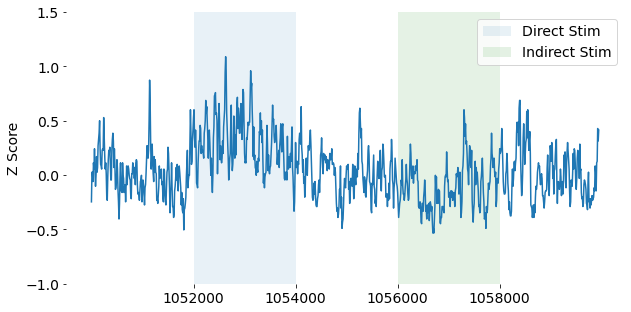

In [224]:
pth = "../../demyelination/data/mgn-to-eaone-reload/activity/"
f = ['spk_mgn-to-eaone-reload_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

# ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
reload_time = 1050000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);
# ax.set_xticks([60, 140], ["Direct Stim", "Indirect Stim"]);

ax.set_ylim(-1, 1.5)

ax.legend()

# ax.set_xlabel("Time");
ax.set_ylabel("Z Score");

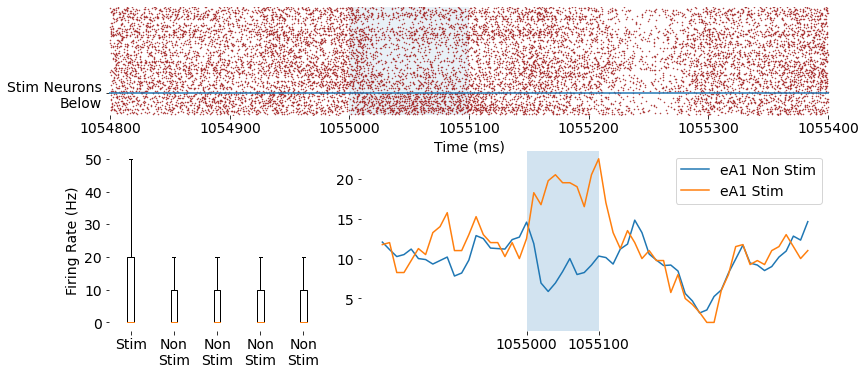

In [175]:
pth = "../../demyelination/data/mgn-to-eaone-reload-singlestim-end/activity/"
f = ['spk_mgn-to-eaone-reload-singlestim-end_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [1055000, 1055100])
ax.axvspan(20, 30, alpha=.2)

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

# ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+1050000)

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 5000ms to 5100ms", fontsize=15);


## Interim State - 500s

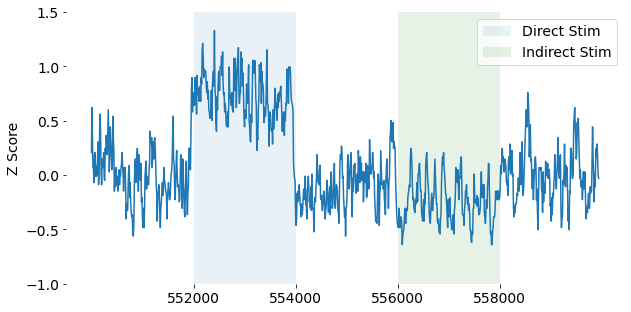

In [225]:
pth = "../../demyelination/data/mgn-to-eaone-reload-halfway/activity/"
f = ['spk_mgn-to-eaone-reload-halfway_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

# ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
reload_time = 550000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);
# ax.set_xticks([60, 140], ["Direct Stim", "Indirect Stim"]);

ax.set_ylim(-1, 1.5)

ax.legend()

# ax.set_xlabel("Time");
ax.set_ylabel("Z Score");

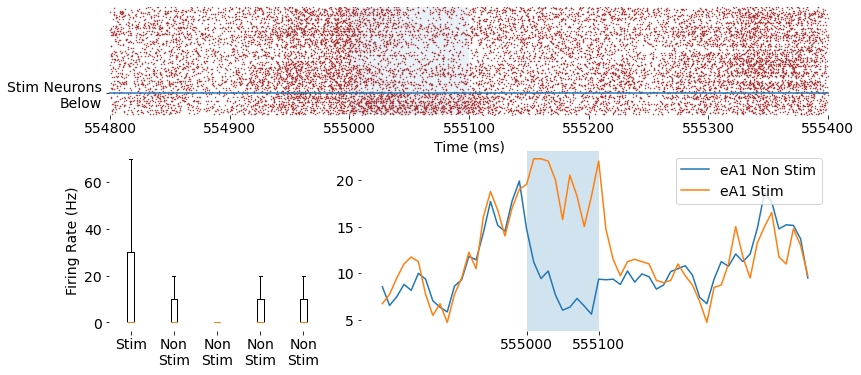

In [176]:
pth = "../../demyelination/data/mgn-to-eaone-reload-singlestim-halfway/activity/"
f = ['spk_mgn-to-eaone-reload-singlestim-halfway_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [555000, 555100])
ax.axvspan(20, 30, alpha=.2)

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+550000)

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 5000ms to 5100ms", fontsize=15);


## Onset of Demyelination

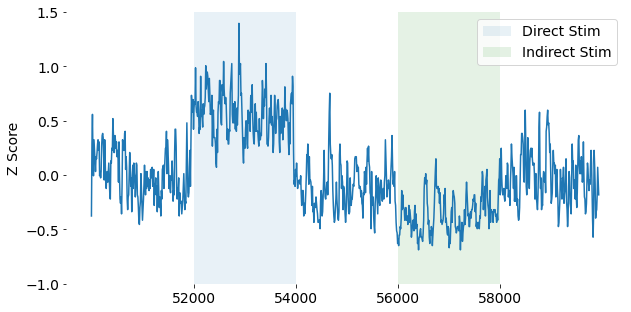

In [228]:
pth = "../../demyelination/data/mgn-to-eaone-reload-start/activity/"
f = ['spk_mgn-to-eaone-reload-start_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[5:])

# ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
reload_time = 50000
ax.set_xticks([200, 400, 600, 800], [reload_time+2000, reload_time+4000, reload_time+6000, reload_time+8000]);

ax.set_ylim(-1, 1.5)

ax.legend()

# ax.set_xlabel("Time");
ax.set_ylabel("Z Score");

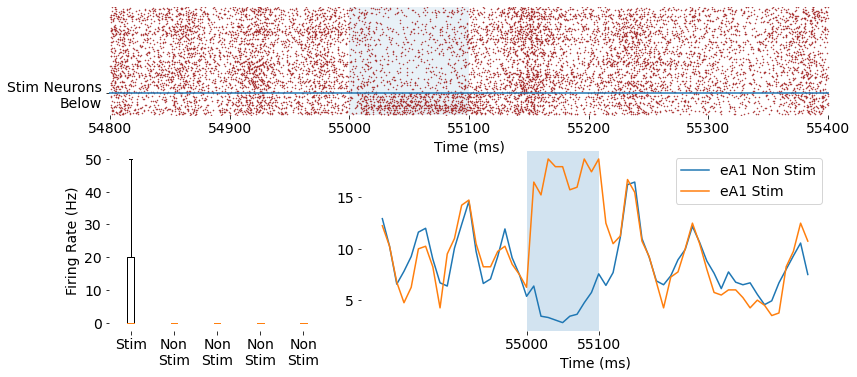

In [177]:
pth = "../../demyelination/data/mgn-to-eaone-reload-singlestim-start/activity/"
f = ['spk_mgn-to-eaone-reload-singlestim-start_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [55000, 55100])
ax.set_xlabel("Time (ms)")
ax.axvspan(20, 30, alpha=.2)

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

xticks = np.array([4800, 4900, 5000, 5100, 5200, 5300, 5400])
ax.set_xticks(xticks, xticks+50000)

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 5000ms to 5100ms", fontsize=15);


## Healthy State

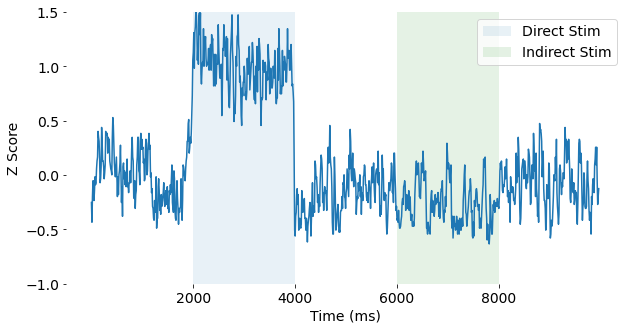

In [229]:
pth = "../../demyelination/data/mgn-to-eaone-reload-healthy/activity/"
f = ['spk_mgn-to-eaone-reload-healthy_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 10

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores[3:])

# ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
ax.set_xticks([200, 400, 600, 800], [2000, 4000, 6000, 8000]);

ax.set_ylim(-1, 1.5)

ax.legend()

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

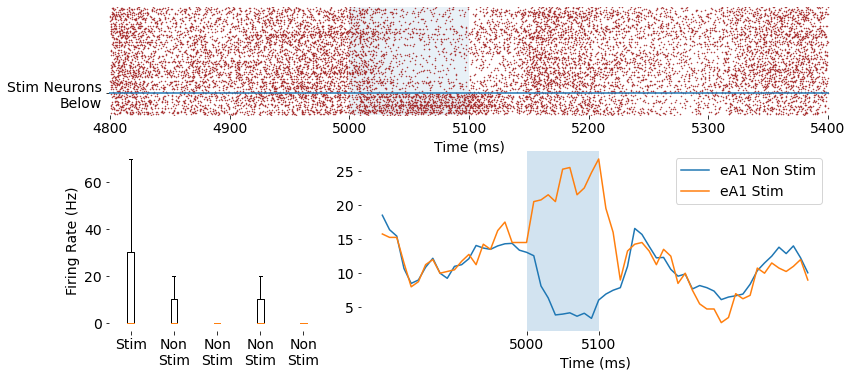

In [178]:
pth = "../../demyelination/data/mgn-to-eaone-reload-singlestim-healthy/activity/"
f = ['spk_mgn-to-eaone-reload-singlestim-healthy_T=0']
p = pd.read_pickle(pth + f[0])

fig = plt.figure()
fig.set_size_inches((10, 5))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non\nStim", "Non\nStim", "Non\nStim", "Non\nStim"])
# ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
ax.set_xticks([20, 30], [5000, 5100])
ax.axvspan(20, 30, alpha=.2)
ax.set_xlabel("Time (ms)")

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

# ax.set_xticks([5000, 5100], [200, 300])
ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

# fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 5000ms to 5100ms", fontsize=15);


## Connectivity Diagrams

In [90]:
exp_name = 'mgn-to-eaone'
dfs = readnet_timeinterval(exp_name, 100 * 1000, 1000 * 1000, 1, "spk_mgn-to-eaone_disabled_conn_ratio=0.5_gr_scale=0.0005_update_interval=50_0")

In [91]:
mgn_eaone_dfs = []
for df in dfs:
    df = df[df.source.between(0, 200) & df.target.between(400, 2400)] # remove all connections which are not MGN->eA1
    mgn_eaone_dfs.append(df)

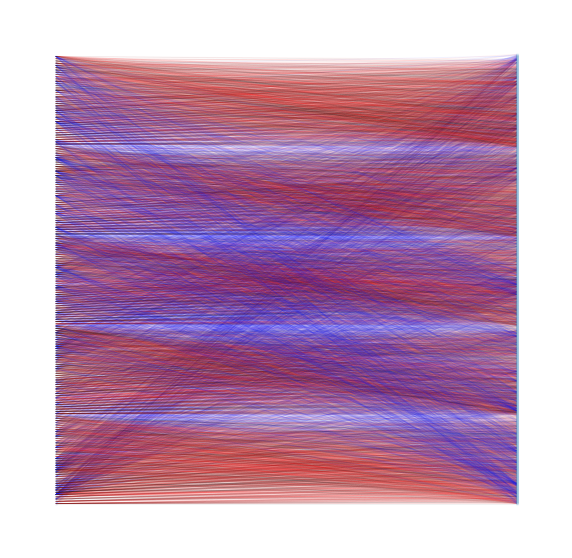

In [219]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

# right_yaxis = ax.twinx()

plotConnectionGraph(mgn_eaone_dfs[-1], ax)

ax.set_frame_on(False)

# ax.set_title("Final State of the Connectivity between the MGN and eA1", {"fontsize":20});

# ax.set_ylabel("MGN")
# right_yaxis.set_ylabel("eA1");


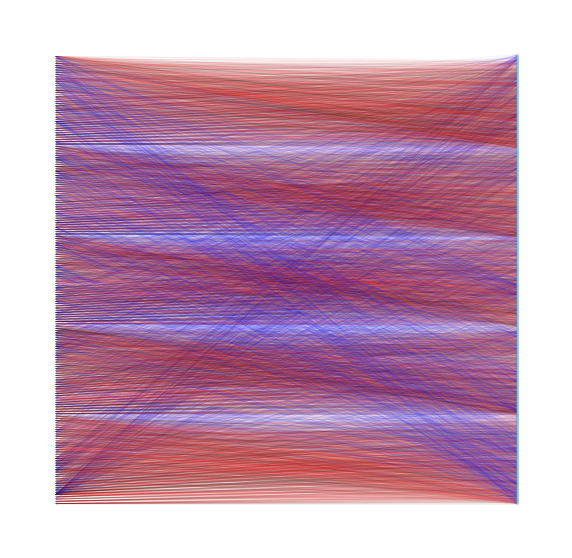

In [220]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

# right_yaxis = ax.twinx()

plotConnectionGraph(mgn_eaone_dfs[4], ax)

ax.set_frame_on(False)

# ax.set_title("Interim State of the Connectivity between the MGN and eA1", {"fontsize":20});

# ax.set_ylabel("MGN")
# right_yaxis.set_ylabel("eA1");


## Model Dynamics

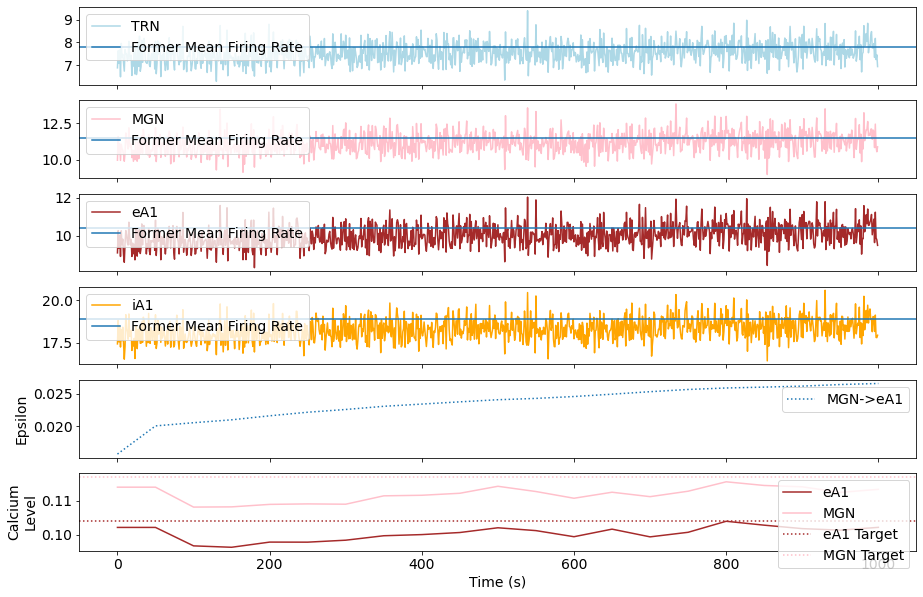

In [231]:
exp_name = 'mgn-to-eaone'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_disabled_conn_ratio=0.5_gr_scale=0.0005_update_interval=50_"

nthread = 1

ex_eA1 = gatherNestConnectivity(pth, \
                                fl, \
                                nthread, "MGN", "eA1")

# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(15, 10)

tstart = 50 * 1000
tstop = 1050 * 1000

resolution = 1 * 1000

trn_spikeobj = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop)
x = trn_spikeobj.firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

mgn_spikeobj = gatherSpikes(pth, fl, nthread, "MGN", 1, 200)
x = mgn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

eaone_spikeobj = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400)
x = eaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

iaone_spikeobj = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop)
x = iaone_spikeobj.firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

x_range = np.arange(0, 1001, 50)

ax[4].plot(x_range, perc_mgn_eA1[2:23], ":", label="MGN->eA1")
ax[4].set_ylabel("Epsilon")

ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'][1:22], label="eA1", color="brown")
ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'][1:22], label="MGN", color="pink")
ax[5].axhline(.104, ls=":", label="eA1 Target", color="brown")
ax[5].axhline(.117, ls=":", label="MGN Target", color="pink")
ax[5].set_ylabel("Calcium\nLevel")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 101, 500), range(0, 1001, 500))

# ax[2].axvline(5, label="Demyelination Onset", color="red")
[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)


7.91
11.625
10.436501
18.776001


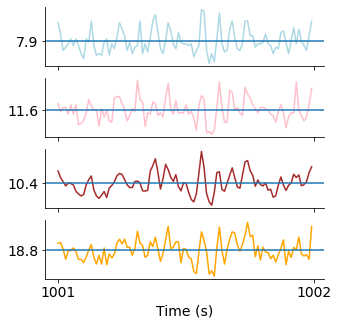

In [213]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.set_size_inches(5, 5)

tstart = 1000 * 1000
tstop = 1001 * 1000
    
resolution = 10

x = trn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.9, label="Mean Firing Rate")
print(np.mean(x))

x = mgn_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.6, label="Mean Firing Rate")
print(np.mean(x))

x = eaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Mean Firing Rate")
print(np.mean(x))

x = iaone_spikeobj.time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.8, label="Mean Firing Rate")
print(np.mean(x))

plt.xlabel("Time (s)")

ax[0].set_yticks([7.9], [7.9])
ax[1].set_yticks([11.6], [11.6])
ax[2].set_yticks([10.4], [10.4])
ax[3].set_yticks([18.8], [18.8])

[_.spines[['right', 'top']].set_visible(False) for _ in ax]

ax[3].set_xticks([0, 100], [1001, 1002]);



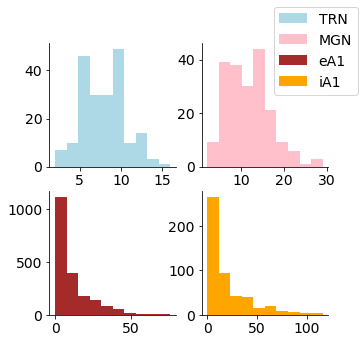

In [214]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(5, 5)

ax[0][0].hist(trn_spikeobj.time_slice(tstart, tstop).mean_rates(), color="lightblue", label='TRN')
ax[0][1].hist(mgn_spikeobj.time_slice(tstart, tstop).mean_rates(), color="pink", label='MGN')
ax[1][0].hist(eaone_spikeobj.time_slice(tstart, tstop).mean_rates(), color="brown", label='eA1')
ax[1][1].hist(iaone_spikeobj.time_slice(tstart, tstop).mean_rates(), color="orange", label='iA1')

ax = ax.reshape(-1)
[_.spines[['right', 'top']].set_visible(False) for _ in ax];

fig.legend()

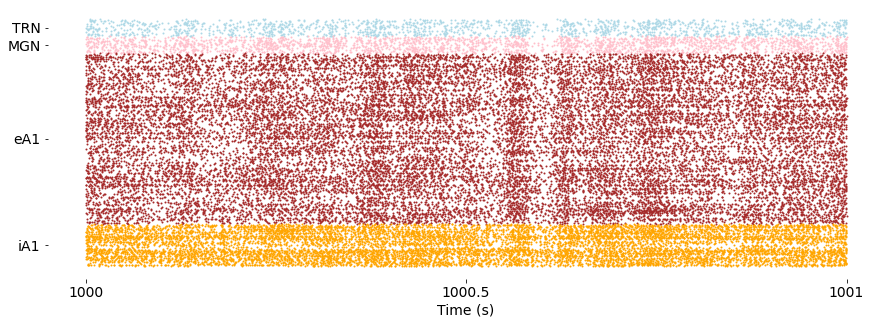

In [210]:

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches(15, 5)

ax.invert_yaxis()

color = {
    trn_spikeobj : 'lightblue',
    mgn_spikeobj : 'pink',
    eaone_spikeobj : 'brown',
    iaone_spikeobj : 'orange'
}

for spikeobj in [trn_spikeobj, mgn_spikeobj, eaone_spikeobj, iaone_spikeobj]:
    d = spikeobj.time_slice(tstart, tstop).raw_data()
    
    if spikeobj == trn_spikeobj:
        d[:, 1] = d[:, 1] - 200
    if spikeobj == mgn_spikeobj:
        d[:, 1] = d[:, 1] + 200

    ax.scatter(
        d[:, 0],
        d[:, 1],
        s=1,
        c=color[spikeobj]
               )
    
ax.set_frame_on(False)

# ax.set_axis_off()

ax.set_yticks([100, 300, 1400, 2650], ["TRN", "MGN", "eA1", "iA1"]);
ax.set_xticks([1000000, 1000500, 1001000], [1000, 1000.5, 1001]);
ax.set_xlabel("Time (s)");


In [232]:
tstart, tstop = 1000 * 1000, 1001 * 1000

print(
    "MFR\n",
    np.mean(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

print(
    "STD MFR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

resolution = 1
print(
    "STD Intantenous FR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True))
)

MFR
 11.625 7.91 10.4365 18.776
STD MFR
 4.993433187697619 2.553801088573658 12.317790700852163 22.187154481816727
STD Intantenous FR
 8.685296 7.1296496 3.1255748 6.793955


In [99]:
from scipy import signal

In [100]:
resolution = 10
ifr_mgn = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_trn = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_eaone = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ifr_iaone = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)

Text(0, 0.5, 'Tonotopic\n\nPower Spectral Density')

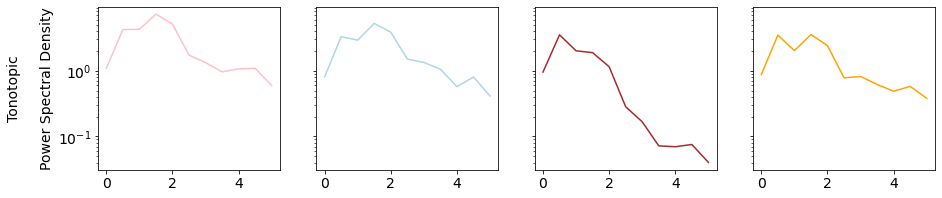

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3), sharey=True)

fs = 10
nps = 20

f, Pxx_den = signal.welch(ifr_mgn, fs, nperseg=nps)
ax[0].semilogy(f, Pxx_den, color='pink')

f, Pxx_den = signal.welch(ifr_trn, fs, nperseg=nps)
ax[1].semilogy(f, Pxx_den, color='lightblue')

f, Pxx_den = signal.welch(ifr_eaone, fs, nperseg=nps)
ax[2].semilogy(f, Pxx_den, color='brown')

f, Pxx_den = signal.welch(ifr_iaone, fs, nperseg=nps)
ax[3].semilogy(f, Pxx_den, color='orange')


ax[0].set_ylabel('Tonotopic\n\nPower Spectral Density')

for idx in range(4):
    ax[idx].set_xticks([0, 1, 2, 3, 4, 5]);
    ax[idx].set_yticks([0.1, 1, 10])


In [102]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "mit"))
)

10.89151971219102 8.585594408343548 15.680161345398984 18.25736855525097


In [103]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "cerina"))
)

0.0 0.0 0.30035417096565176 1.0540261496620464


In [104]:
timebin = 20

ppc = {'MGN' : [], 'TRN' : [], 'eA1' : [], 'iA1' : []}

for _ in range(10):
    ppc['MGN'].append(mgn_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['TRN'].append(trn_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['eA1'].append(eaone_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])
    ppc['iA1'].append(iaone_spikeobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=timebin)[0])

print(
    np.mean(ppc['MGN']),
    np.mean(ppc['TRN']),
    np.mean(ppc['eA1']),
    np.mean(ppc['iA1']),
)
    

0.01740167625926783 0.0194908124976906 0.007390390532965157 0.006102141112203091


In [244]:
tstart, tstop = 25 * 1000, 75 * 1000

timebin = 1000

mgn_fr = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(timebin, average=True)
trn_fr = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(timebin, average=True)
eaone_fr = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(timebin, average=True)
iaone_fr = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(timebin, average=True)

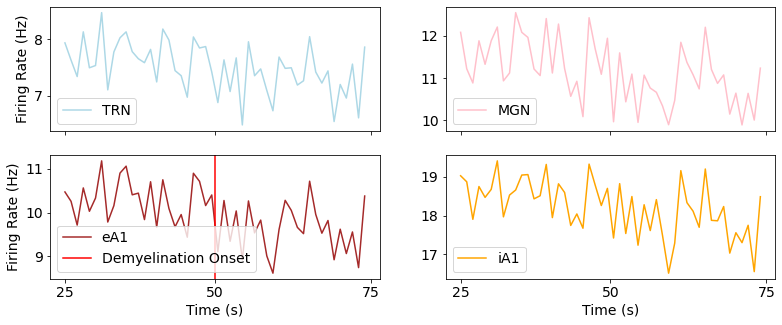

In [245]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(13, 5)

ax = ax.flatten()

ax[0].plot(trn_fr, label='TRN', c='lightblue')
ax[1].plot(mgn_fr, label='MGN', c='pink')
ax[2].plot(eaone_fr, label='eA1', c='brown')
ax[3].plot(iaone_fr, label='iA1', c='orange')

ax[2].axvline(24.5, label="Demyelination Onset", color="red")

[ax[_].set_xticks([0, 24.5, 50], [25, 50, 75]) for _ in [2, 3]]

[ax[_].legend() for _ in range(4)];
[ax[_].set_ylabel("Firing Rate (Hz)") for _ in [0, 2]];
[ax[_].set_xlabel("Time (s)") for _ in [2, 3]];

In [107]:
# gathering spike objects
trn_spkobj = gatherSpikes(pth, fl, nthread, "TRN", 201, 400)
mgn_spkobj = gatherSpikes(pth, fl, nthread, "MGN", 1, 200)
eaone_spkobj = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400)
iaone_spkobj = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900)

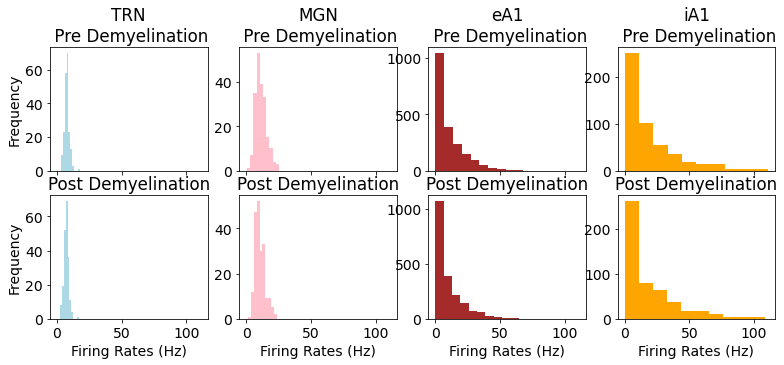

In [249]:

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True)
fig.set_size_inches(13, 5)

den = False

tstart, tstop = 45000, 50000
ax[0][0].hist(trn_spkobj.time_slice(tstart, tstop).mean_rates(), color='lightblue', density=den);
ax[0][1].hist(mgn_spkobj.time_slice(tstart, tstop).mean_rates(), color='pink', density=den);
ax[0][2].hist(eaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='brown', density=den);
ax[0][3].hist(iaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='orange', density=den);


tstart, tstop = 50000, 55000
ax[1][0].hist(trn_spkobj.time_slice(tstart, tstop).mean_rates(), color='lightblue', density=den);
ax[1][1].hist(mgn_spkobj.time_slice(tstart, tstop).mean_rates(), color='pink', density=den);
ax[1][2].hist(eaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='brown', density=den);
ax[1][3].hist(iaone_spkobj.time_slice(tstart, tstop).mean_rates(), color='orange', density=den);

for idx, population in enumerate(["TRN\n", "MGN\n", "eA1\n", "iA1\n"]):
    ax[0][idx].set_title(population + " Pre Demyelination")
    ax[1][idx].set_title("Post Demyelination")

[ax[1][_].set_xlabel("Firing Rates (Hz)") for _ in range(4)];
[ax[_][0].set_ylabel("Frequency") for _ in range(2)];


In [109]:
tstart, tstop = 45000, 50000
mgn_spkobj.time_slice(tstart, tstop).pairwise_pearson_corrcoeff(nb_pairs=40000, time_bin=25)

(0.020039545641855432, 0.08495580812261953)

# MGN Stim Sensitivity

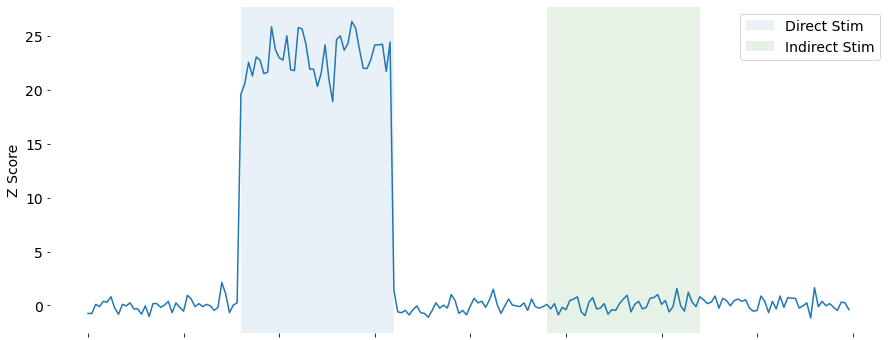

In [110]:
pth = "../../demyelination/data/mgn-to-eaone-reload/activity/"
f = ['spk_mgn-to-eaone-reload_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['MGN'].id_slice(range(1, 41))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 50

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(15, 6)

# ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1, label="Direct Stim");
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1, facecolor='g', label="Indirect Stim");

ax.plot(z_scores)

ax.tick_params(labelbottom=False)
ax.set_frame_on(False)
# ax.set_xticks([60, 140], ["Direct Stim", "Indirect Stim"]);

ax.legend()

# ax.set_xlabel("Time");
ax.set_ylabel("Z Score");